In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.covariance import OAS, EmpiricalCovariance, MinCovDet, EllipticEnvelope, GraphicalLassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
import pickle
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neighbors import NearestNeighbors

plt.style.use("seaborn-v0_8")

In [6]:
random_state = 42

df = pd.read_csv("train.csv")

df_X = df.iloc[:, 1:]
df_y = df.iloc[:, 0]

# "stratify" is set because the target is very imbalanced
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, stratify=df_y, random_state=random_state)
print("Train: {}\nTest: {}".format(X_train.shape, X_test.shape))

Train: (176522, 90)
Test: (75653, 90)


---
# Preprocessing

- [Whitening transformation](https://en.wikipedia.org/wiki/Whitening_transformation) is tested
- [Shrinkage, Oracle Approximating Shrinkage (OAS)](https://en.wikipedia.org/wiki/Shrinkage_(statistics)#:~:text=In%20statistics%2C%20shrinkage%20is%20the,coefficient%20of%20determination%20'shrinks') is tested because requires normal distributed data
- [Empirical covariance](https://scikit-learn.org/stable/modules/covariance.html#empirical-covariance) is tested because requires normal distributed data
- [EllipticEnvelope](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope) is tested because it's robust to anomalies, requires normal and unimodal distributed data
- LDA with eigenvalues solver for dimensionality reduction

In [3]:
# step_name, [(transformer_name, transformer_constructor()), ...], step_param_grid
transformers_list = [
    # ("raw", [("raw", "passthrough")], {}),  # does nothing to the data
    # ("std-scaled", [("std-scaler", preprocessing.StandardScaler())], {}),  # DA TOGLIEREEEE???????????
    # ("min-maxed", [("min-max", preprocessing.MinMaxScaler())], {}),  # DA TOGLIEREEEE???????????
    # (
    #     "min-max + pca 0.95",
    #     [("min-max", preprocessing.MinMaxScaler()), ("pca", PCA(random_state=random_state))],
    #     {
    #         "pca__svd_solver": ["full"],
    #         "pca__n_components": [0.95],
    #         "pca__whiten": [True, False],
    #     },
    # ),
    (
        "min-max + lda2",
        [("min-max", preprocessing.MinMaxScaler()), ("lda", LinearDiscriminantAnalysis())],
        {
            "lda__solver": ["eigen"],
            "lda__shrinkage": [None],
            "lda__covariance_estimator": [
                EllipticEnvelope(random_state=random_state),
                EmpiricalCovariance(),
                # GraphicalLassoCV(cv=3), # too much computational expensive
                OAS(),
                None,
            ],
        },
    ),
    # (
    #     "std-scaler + lda2",
    #     [("std-scaler", preprocessing.StandardScaler()), ("lda", LinearDiscriminantAnalysis())],
    #     {
    #         "lda__solver": ["eigen"],
    #         "lda__shrinkage": [None],
    #         "lda__covariance_estimator": [
    #             EllipticEnvelope(assume_centered=True, random_state=random_state),
    #             EmpiricalCovariance(assume_centered=True),
    #             # GraphicalLassoCV(cv=3, assume_centered=True), # too much computational expensive
    #             OAS(assume_centered=True),
    #             None,
    #         ],
    #     },
    # ),
    # (
    #     "ica",
    #     [("ica", FastICA(random_state=random_state))],
    #     {
    #         "ica__whiten": ["arbitrary-variance", "unit-variance"],
    #         "ica__whiten_solver": ["eigh"],
    #         "ica__fun": ["logcosh", "exp", "cube"],
    #         "ica__max_iter": [400],
    #     },
    # ),
]

---
---
# Modeling
- For every preprocess method defined above, execute a GridSearch over the preprocess parameters plus the model parameters
- Then it's chosen the best model with the best preprocess method looking at the R^2 score
- "StratifiedKFold" is chosen to keep the proportion of imbalanced target lables

In [4]:
def gridSearch(name_estimator, estimator, param_estimator, cv):
    searches = {}
    predictions = {}
    for name_step, transformers, param_grid in transformers_list:
        pipe = Pipeline([*transformers, (name_estimator, estimator)])
        gs = GridSearchCV(
            pipe, param_grid={**param_estimator, **param_grid}, n_jobs=-1, cv=cv, verbose=3, pre_dispatch=8
        )

        gs.fit(X_train.values, y_train)

        y_pred = gs.best_estimator_.predict(X_test.values)

        searches[name_step] = gs
        predictions[name_step] = y_pred

        print(
            "----> {} data. Params: {}. R^2: {}. MSE: {}".format(
                name_step, gs.best_params_, r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)
            )
        )
    return searches, predictions

In [49]:
def print_store_results(searches: dict, predictions: dict, name_est):
    best_r2_score = -100
    best_preprocessor = []
    best_estimator = None
    best_search_name = None

    for name_step, gs in searches.items():
        r2 = r2_score(y_test, predictions[name_step])

        if r2 > best_r2_score:
            best_r2_score = r2
            best_search_name = name_step
            best_preprocessor = gs.best_estimator_[:-1]  # take all but estimator
            best_estimator = gs.best_estimator_[-1]

        print(
            "----> {} data. Params: {}. R^2: {}. MSE: {}".format(
                name_step, gs.best_params_, r2, mean_squared_error(y_test, predictions[name_step])
            )
        )

        if name_step in [
            "min-max + pca",
            "min-max + pca 0.95",
            "min-max + lda1",
            "min-max + lda2",
            "min-max + lda3",
            "std-scaler + lda2",
        ]:
            ratio = gs.best_estimator_[1].explained_variance_ratio_
            print(
                "\t\t{}: number of components={}, total variance={}".format(
                    name_step, len(ratio), np.flip(ratio.cumsum())[0]
                )
            )
        if name_step in ["lda1", "lda2", "lda3"]:
            ratio = gs.best_estimator_[0].explained_variance_ratio_
            print(
                "\t\t{}: number of components={}, total variance={}".format(
                    name_step, len(ratio), np.flip(ratio.cumsum())[0]
                )
            )
        if name_step in ["min-max + ica"]:
            print("\t\t{}: number of components={}".format(name_step, len(gs.best_estimator_[1].components_)))

    file = open(name_est + "_preproc_" + ".save", "wb")
    pickle.dump(best_preprocessor, file)
    file = open(name_est + "_model_" + ".save", "wb")
    pickle.dump(best_estimator, file)
    file.close()

    print("\nSAVED: ----> {} data. R^2: {}".format(best_search_name, best_r2_score))

    _, ax = plt.subplots(figsize=(10, 10))
    ConfusionMatrixDisplay.from_predictions(y_test, np.round(predictions[best_search_name])).plot(
        ax=ax, xticks_rotation=45, include_values=False, cmap="icefire"
    )
    plt.grid(None)
    plt.tight_layout()
    plt.show()

---
## Linear Regression
- It appears that PCA with an explained variance ratio of 0.95 performs much better with a min-max scaling (54 components) instead of a standard-scaling (67 components).
- Overall, looking at R^2 and MSE, the best model is LDA with explained variance ratio of almost 1 and 53 components. No differencies between a row data or pior min-max or standard-scaling, or between different solvers ("eigen", "svd") or between different covariance estimators ("Empirical", "LedoitWolf", "MinCovDet", "OAS")

In [ ]:
cv = StratifiedKFold(n_splits=3)

param_estimator = {}

searches, predictions = gridSearch("lr", LinearRegression(), param_estimator, cv)

----> min-max + lda2 data. Params: {'lda__covariance_estimator': EllipticEnvelope(random_state=42), 'lda__shrinkage': None, 'lda__solver': 'eigen', 'rf__criterion': 'squared_error', 'rf__max_samples': 0.025, 'rf__n_estimators': 500}. R^2: 0.29396840748747954. MSE: 77.80217040450476
		min-max + lda2: number of components=53, total variance=1.1984870090370168

SAVED: ----> min-max + lda2 data. R^2: 0.29396840748747954


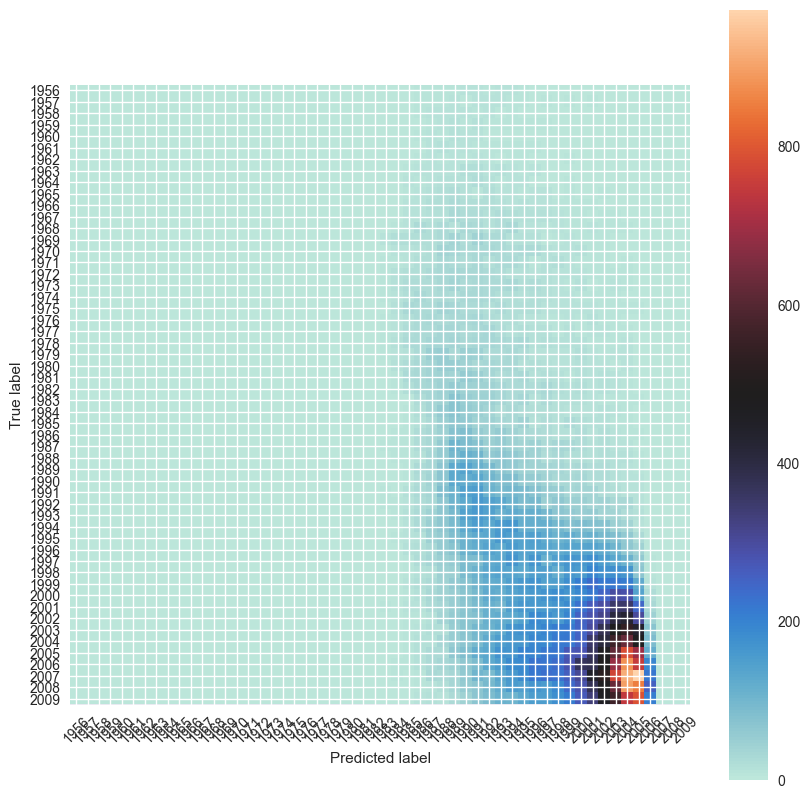

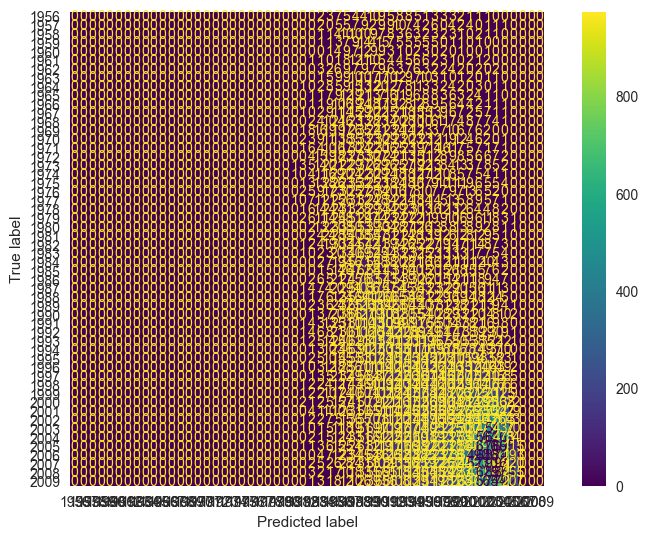

In [50]:
print_store_results(searches, predictions, "lr")

---
## RandomForestRegressor
- PCA with an explained variance ratio of 0.95 performs much better with a min-max scaling (54 components) instead of a standard-scaling (67 components).
- Less trees with all samples for each tree gave worse results
- The parameter "max_samples=0.1" was set to speed up the preliminary search looking for the best parameters.

In [8]:
cv = StratifiedKFold(n_splits=3)

param_estimator = {
    "rf__max_samples": [0.025],
    "rf__criterion": ["squared_error"],
    "rf__n_estimators": [500],
}

searches, predictions = gridSearch("rf", RandomForestRegressor(n_jobs=-1), param_estimator, cv)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
----> min-max + lda2 data. Params: {'lda__covariance_estimator': EllipticEnvelope(random_state=42), 'lda__shrinkage': None, 'lda__solver': 'eigen', 'rf__criterion': 'squared_error', 'rf__max_samples': 0.025, 'rf__n_estimators': 500}. R^2: 0.29396840748747954. MSE: 77.80217040450476


In [9]:
print_store_results(searches, predictions, "rf")

----> min-max + lda2 data. Params: {'lda__covariance_estimator': EllipticEnvelope(random_state=42), 'lda__shrinkage': None, 'lda__solver': 'eigen', 'rf__criterion': 'squared_error', 'rf__max_samples': 0.025, 'rf__n_estimators': 500}. R^2: 0.29396840748747954. MSE: 77.80217040450476
		min-max + lda2: number of components=53, total variance=1.1984870090370168

SAVED: ----> min-max + lda2 data. R^2: 0.29396840748747954


---
## KNN

In [28]:
cv = StratifiedKFold(n_splits=3)

param_estimator = {
    "knr__n_neighbors": [30],
    "knr__weights": ["uniform", "distance"],
    "knr__metric": [
        "cityblock",
        "cosine",
        "euclidean",
        "haversine",
        "nan_euclidean",
    ],
}

searches, predictions = gridSearch("knr", KNeighborsRegressor(n_jobs=-1), param_estimator, cv)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [19]:
print_store_results(searches, predictions, "knr")

----> raw data. Params: {'knr__n_neighbors': 30, 'knr__weights': 'distance'}. R^2: 0.08720402917140713. MSE: 100.58938393160089
----> std-scaled data. Params: {'knr__n_neighbors': 30, 'knr__weights': 'distance'}. R^2: 0.209118908521013. MSE: 87.15446200185112
----> min-maxed data. Params: {'knr__n_neighbors': 30, 'knr__weights': 'distance'}. R^2: 0.2629406287416589. MSE: 81.22335159804501
----> min-max + pca 0.95 data. Params: {'knr__n_neighbors': 30, 'knr__weights': 'distance', 'pca__n_components': 0.95, 'pca__svd_solver': 'full', 'pca__whiten': False}. R^2: 0.2631206297821246. MSE: 81.20351562774482
		min-max + pca 0.95: number of components=55, total variance=0.9510242745378801
----> min-max + lda2 data. Params: {'knr__n_neighbors': 30, 'knr__weights': 'distance', 'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen'}. R^2: 0.2667276479794468. MSE: 80.80602511519429
		min-max + lda2: number of components=53, total variance=1.1026680960934392
----> std-sc

---
## SVM

In [20]:
cv = StratifiedKFold(n_splits=5)

param_estimator = {
    "svr__C": [
        *range(1, 10, 1),
        *range(10, 100, 10),
        *range(100, 1000, 100),
    ],
    "svr__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "svr__gamma": ["scale", "auto"],
}

searches, predictions = gridSearch("svr", SVR(), param_estimator, cv)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


ValueError: Invalid parameter 'probability' for estimator SVR(C=1, kernel='linear'). Valid parameters are: ['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'].

In [ ]:
print_store_results(searches, predictions, "svr")